In [1]:
import warnings
import os
import copy
from sklearnex import patch_sklearn
import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
warnings.filterwarnings("ignore")

import uuid
from sklearn.experimental import enable_iterative_imputer
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.impute import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.kernel_approximation import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *
from sklearn.covariance import *
from collections import Counter
import sklearn
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.calibration import *
import joblib
from pprint import pprint as pp

pd.options.compute.use_numba = True
pd.options.compute.use_numexpr = True
pd.options.compute.use_bottleneck = True
pd.options.display.max_columns = 90
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import (
    ADASYN,
    SMOTE,
    RandomOverSampler,
    SVMSMOTE,
    SMOTENC,
    SMOTEN,
    BorderlineSMOTE,
    KMeansSMOTE,
)

%matplotlib inline
plt.style.use("fivethirtyeight")

import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory

# patch_sklearn()
KAGGLE_ENV = 1
DATA_INPUT = "/kaggle/input/marketing-strategy-personalised-offer/"
DATA_OUTPUT = "/kaggle/working/"
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd or "u170690" in cwd:
    KAGGLE_ENV = 0
    DATA_INPUT = "kaggle/input/marketing-strategy-personalised-offer/"
    DATA_OUTPUT = "kaggle/working/"
CACHE = Memory(DATA_OUTPUT + "joblib", verbose=0)
patch_sklearn()

data = pd.read_csv(DATA_INPUT + "train_data.csv")
eval_data = pd.read_csv(DATA_INPUT + "test_data.csv")


def gen_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=10
    )
    return X_train, X_test, y_train, y_test


def quick_test(X):
    clfs = [
        RandomForestClassifier(class_weight="balanced_subsample", random_state=42),
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        LogisticRegressionCV(max_iter=10000, class_weight="balanced", random_state=42),
    ]
    y = data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.5)
    for clf in clfs:
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"{clf.__class__.__name__} :: {score}")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# _ = data.isna().sum().plot(kind="bar", rot=90, logy=True, figsize=(10, 8))
# data.nunique()
n_c = [
    "Job/Job Industry",
    "Marital Status",
    "restaurant type",
    "Customer type",
    "Climate",
    "Qualification",
    "drop location",
    "car",
]
# for c in n_c:
#     print(c,"\t:\t",data[c].unique(),'\n')

```text
Job/Job Industry 	:	 ['Unemployed' 'Arts Design Entertainment Sports & Media' 'Sales & Related'
 'Student' 'Business & Financial' 'Computer & Mathematical'
 'Office & Administrative Support' 'Management' 'Healthcare Support'
 'Life Physical Social Science' 'Installation Maintenance & Repair'
 'Legal' 'Community & Social Services' 'Education&Training&Library'
 'Construction & Extraction' 'Healthcare Practitioners & Technical'
 'Transportation & Material Moving' 'Retired' 'Architecture & Engineering'
 'Production Occupations' 'Farming Fishing & Forestry'
 'Protective Service' 'Personal Care & Service'
 'Food Preparation & Serving Related'
 'Building & Grounds Cleaning & Maintenance'] 

Marital Status 	:	 ['Married partner' 'Single' 'Divorced' 'Unmarried partner' 'Widowed'] 

restaurant type 	:	 ['4 star restaurant' 'Take-away restaurant' 'Cold drinks'
 'Restaurant with pub' '2 star restaurant'] 

Customer type 	:	 ['Individual' 'With Family' 'With Kids' 'With Colleagues'] 

Climate 	:	 ['Spring' 'Summer' 'Winter'] 

Qualification 	:	 ['Bachelors degree' 'Some college - no degree'
 'Graduate degree (Masters or Doctorate)' 'Associates degree'
 'High School Graduate' 'Some High School'] 

drop location 	:	 ['Location B' 'Location A' 'Location C'] 

car 	:	 [nan 'Mazda5' 'Car that is too old to install Onstar :D' 'crossover'
 'Scooter and motorcycle' 'do not drive'] 

```

### Data Cleaning If possible Reload Last Saved Data

In [32]:
data = pd.read_csv(DATA_INPUT + "train_data.csv")
eval_data = pd.read_csv(DATA_INPUT + "test_data.csv")
ques = "Do you want to use new data?"
ans = input(prompt=ques)
if ans.lower() == "y":

    def convert_to_hours(row):
        if "hours" in row["offer expiration"]:
            #         row['offer expiration'] = int(row['offer expiration'][:-5])
            row["offer expiration"] = 0
        elif "days" in row["offer expiration"]:
            #         row['offer expiration'] = int(row['offer expiration'][:-4])*24
            row["offer expiration"] = 1
        return row

    def save_data():
        global data, eval_data
        data.to_parquet(DATA_OUTPUT + "data.parquet")
        eval_data.to_parquet(DATA_OUTPUT + "eval_data.parquet")

    data = data.apply(convert_to_hours, axis=1)
    eval_data = eval_data.apply(convert_to_hours, axis=1)

    def pythonise_col_names(df: pd.DataFrame):
        col_names = list(df.columns)
        rename_stubs = {}
        for x in col_names:
            if x == "Offer Accepted":
                r = "target"
                rename_stubs[x] = r
            elif "/" in x:
                r = x.split("/")[1]
                r = r.replace(" ", "_").lower()
                rename_stubs[x] = r
            elif "-" in x:
                r = x.replace("-", "_").lower()
                r = r.replace(" ", "_").lower()
                rename_stubs[x] = r
            elif " " in x:
                r = x.replace(" ", "_").lower()
                rename_stubs[x] = r
            else:
                r = x.lower()
                rename_stubs[x] = r
        return rename_stubs

    data.rename(pythonise_col_names(data), inplace=True, axis=1)
    eval_data.rename(pythonise_col_names(eval_data), inplace=True, axis=1)
    gender_code = {"Male": 0, "Female": 1}

    def binarize_gender(row):
        global gender_code
        row["gender"] = gender_code[row["gender"]]
        return row

    data = data.apply(binarize_gender, axis=1)
    eval_data = eval_data.apply(binarize_gender, axis=1)

    ages_ord = ["below21", "21", "26", "31", "36", "41", "46", "50plus"]
    ordinal_age_codes = {x: idx + 1 for idx, x in enumerate(ages_ord)}
    income_codes = {
        "Less than ₹12500": 1,
        "₹12500 - ₹24999": 2,
        "₹25000 - ₹37499": 3,
        "₹37500 - ₹49999": 4,
        "₹50000 - ₹62499": 5,
        "₹62500 - ₹74999": 6,
        "₹75000 - ₹87499": 7,
        "₹87500 - ₹99999": 8,
        "₹100000 or More": 9,
    }
    ordinal_quali_codes = {
        "Bachelors degree": 5,
        "Some college - no degree": 3,
        "Graduate degree (Masters or Doctorate)": 6,
        "Associates degree": 4,
        "High School Graduate": 2,
        "Some High School": 1,
    }
    data["ordinal__income_range"] = 0
    eval_data["ordinal__income_range"] = 0
    data["ordinal__age"] = 0
    eval_data["ordinal__age"] = 0
    data["ordinal__qualif"] = 0
    eval_data["ordinal__qualif"] = 0

    def codify_special_ordinal_range(row):
        global income_codes, ordinal_age_codes
        row["ordinal__income_range"] = income_codes[row["income_range"]]
        row["ordinal__age"] = ordinal_age_codes[row["age"]]
        row["ordinal__qualif"] = ordinal_quali_codes[row["qualification"]]
        return row

    data = data.apply(codify_special_ordinal_range, axis=1)
    eval_data = eval_data.apply(codify_special_ordinal_range, axis=1)

    ordinal_category_codes = {
        "4~8": 4,
        "less1": 2,
        "never": 1,
        "1~3": 3,
        "gt8": 5,
        np.nan: np.nan,
    }

    # data = data.apply(codify_cold_drink_consumption,axis=1)
    # eval_data = eval_data.apply(codify_cold_drink_consumption,axis=1)
    ord_cols = [
        "restaur_spend_less_than20",
        "no_take_aways",
        "restaur_spend_greater_than20",
        "no_visited_bars",
        "no_visited_cold_drinks",
    ]
    col_ord_names = ["ordinal__" + x for x in ord_cols]
    data[col_ord_names] = 0
    eval_data[col_ord_names] = 0

    def codify_ordinal_columns(row):
        global col_ord_names, ordinal_category_codes, ord_cols
        for ord_col, col_ord_name in zip(ord_cols, col_ord_names):
            try:
                row[col_ord_name] = int(ordinal_category_codes[row[ord_col]])
            except ValueError:
                row[col_ord_name] = ordinal_category_codes[row[ord_col]]
        return row

    data = data.apply(codify_ordinal_columns, axis=1)
    eval_data = eval_data.apply(codify_ordinal_columns, axis=1)

    """
    Car Feature:
    Label NaN as unknown for now
    """
    data.car.fillna("unknown", inplace=True)
    eval_data.car.fillna("unknown", inplace=True)

    nominal_cs = [
        "restaurant_type",
        "marital_status",
        #         "climate",
        "drop_location",
        "job_industry",
        "customer_type",
        "car",
    ]
    nominal_col_names = ["nominal__" + x for x in nominal_cs]
    master_nominals = pd.concat(
        [data[nominal_cs], eval_data[nominal_cs]], ignore_index=True, axis=0
    )
    nominal_encoder = {nc: {} for nc in nominal_cs}
    for c in nominal_cs:
        unique_vals = list(master_nominals[c].unique())
        nominal_codes = {x: idx for idx, x in enumerate(unique_vals)}
        nominal_encoder[c] = nominal_codes
    data[nominal_col_names] = 0
    eval_data[nominal_col_names] = 0
    data["interval__season"] = 0
    eval_data["interval__season"] = 0
    season_code = {"Spring": 1, "Summer": 2, "Winter": 3}

    def assign_numeric_seasons(row):
        row["interval__season"] = season_code[row["climate"]]
        return row

    data = data.apply(assign_numeric_seasons, axis=1)
    eval_data = eval_data.apply(assign_numeric_seasons, axis=1)

    def codify_nominal_columns(row):
        global nominal_col_names, nominal_encoder, nominal_cs
        for nom_col, col_nom_name in zip(nominal_cs, nominal_col_names):
            try:
                row[col_nom_name] = int(nominal_encoder[nom_col][row[nom_col]])
            except ValueError:
                row[col_nom_name] = nominal_encoder[nom_col][row[nom_col]]
        return row

    data = data.apply(codify_nominal_columns, axis=1)
    eval_data = eval_data.apply(codify_nominal_columns, axis=1)

    def drop_const_and_enc_columns(df):
        cols_to_drop = [
            "restaur_spend_less_than20",
            "no_take_aways",
            "restaur_spend_greater_than20",
            "no_visited_bars",
            "no_visited_cold_drinks",
            "restaurant_type",
            "marital_status",
            "climate",
            "qualification",
            "drop_location",
            "job_industry",
            "customer_type",
            "car",
            "income_range",
            "travelled_more_than_5mins_for_offer",
            "age",
        ]
        df = df.drop(cols_to_drop, axis=1)
        return df

    data = drop_const_and_enc_columns(data)
    eval_data = drop_const_and_enc_columns(eval_data)

    data_original_col_order = [
        "offer_expiration",
        "ordinal__income_range",
        "ordinal__no_visited_cold_drinks",
        "travelled_more_than_15mins_for_offer",
        "ordinal__restaur_spend_less_than20",
        "nominal__marital_status",
        "nominal__restaurant_type",
        "ordinal__age",
        "prefer_western_over_chinese",
        "travelled_more_than_25mins_for_offer",
        "ordinal__no_visited_bars",
        "gender",
        "nominal__car",
        "restuarant_same_direction_house",
        "cooks_regularly",
        "nominal__customer_type",
        "ordinal__qualif",
        "is_foodie",
        "ordinal__no_take_aways",
        "nominal__job_industry",
        "restuarant_opposite_direction_house",
        "has_children",
        "visit_restaurant_with_rating_(avg)",
        "temperature",
        "ordinal__restaur_spend_greater_than20",
        "travel_time",
        "interval__season",
        "nominal__drop_location",
        "prefer_home_food",
        "target",
    ]
    eval_data_original_col_order = copy.deepcopy(data_original_col_order)
    eval_data_original_col_order.remove("target")

    data = data.loc[:, data_original_col_order]
    eval_data = eval_data.loc[:, eval_data_original_col_order]
    binary_features = [
        "offer_expiration",
        "travelled_more_than_15mins_for_offer",
        "prefer_western_over_chinese",
        "travelled_more_than_25mins_for_offer",
        "restuarant_same_direction_house",
        "cooks_regularly",
        "is_foodie",
        "restuarant_opposite_direction_house",
        "has_children",
        "prefer_home_food",
        "gender",
    ]
    b_f_rn = {x: "binary__" + x for x in binary_features}
    data.rename(b_f_rn, axis=1, inplace=True)
    eval_data.rename(b_f_rn, axis=1, inplace=True)
    remaining_ordinals = {
        "visit_restaurant_with_rating_(avg)": "ordinal__type_of_rest_rating",
        "temperature": "interval__temperature",
        "travel_time": "interval__travel_time",
    }

    def rename_remaining_ord(df):
        df = df.rename(remaining_ordinals, axis=1)
        return df

    data = rename_remaining_ord(data)
    eval_data = rename_remaining_ord(eval_data)

    target_codes = {"Yes": 1, "No": 0}

    def binarize_target(row):
        global target_codes
        row["target"] = target_codes[row["target"]]
        return row

    data = data.apply(binarize_target, axis=1)
    X = data[eval_data.columns]
    y = data.target
    X_eval = eval_data

    def impute_values(X, y, X_eval):
        imputer = IterativeImputer(
            estimator=RandomForestClassifier(
                class_weight="balanced", random_state=42, n_jobs=-1
            ),
            sample_posterior=False,
            initial_strategy="most_frequent",
            random_state=42,
        )
        #     data.isna().sum()

        with parallel_backend("threading", n_jobs=24):
            data_enc = imputer.fit_transform(X)
            eval_data_enc = imputer.transform(eval_data)
        return data_enc, eval_data_enc

    data_enc, eval_data_enc = impute_values(X, y, X_eval)
    data.loc[:, eval_data.columns] = data_enc
    eval_data.loc[:, :] = eval_data_enc
    data = data.astype(np.uint32)
    eval_data = eval_data.astype(np.uint32)
    save_data()
else:
    data = pd.read_parquet(DATA_OUTPUT + "data.parquet")
    eval_data = pd.read_parquet(DATA_OUTPUT + "eval_data.parquet")


"""
Degree Of Closeness Rather than Nominal Drop Variable.
"""

closeness_ranks = {0: 3, 1: 2, 2: 1}


def rank_closeness(row):
    """
    It makes sense to rename the nominal drop Location to much more meaningful
    Ordinal Variable based on General Closeness to target Pop.
    """
    row["nominal__drop_location"] = closeness_ranks[row["nominal__drop_location"]]
    return row


data = data.apply(rank_closeness, axis=1)
eval_data = eval_data.apply(rank_closeness, axis=1)
data.rename({"nominal__drop_location": "ordinal__dest_distance"}, axis=1, inplace=True)
eval_data.rename(
    {"nominal__drop_location": "ordinal__dest_distance"}, axis=1, inplace=True
)


def html_px(chart):
    f_name = str(uuid.uuid1())[:8] + ".html"
    f_dest = "/home/u164131/msiit/charts/"
    with open(f_dest + f_name, "w+") as fp:
        fp.write(chart.to_html())
    return f_dest + f_name


"""
Variable Groups
"""
nominal = [x for x in eval_data.columns if "nominal_" in x]
ordinal = [x for x in eval_data.columns if "ordinal_" in x]
binary = [x for x in eval_data.columns if "binary_" in x]
interval = [x for x in eval_data.columns if "interval_" in x]

bio = [
    "binary__gender",
    "ordinal__age",
]
personal_info = [
    "nominal__marital_status",
    "binary__has_children",
    "nominal__customer_type",
]
prefs = [
    "binary__prefer_home_food",
    "binary__is_foodie",
    "binary__prefer_western_over_chinese",
    "binary__cooks_regularly",
]
distance = [
    "binary__travelled_more_than_15mins_for_offer",
    "binary__travelled_more_than_25mins_for_offer",
    "binary__restuarant_opposite_direction_house",
    "binary__restuarant_same_direction_house",
]
usage_info = [
    "ordinal__no_visited_cold_drinks",
    "ordinal__restaur_spend_less_than20",
    "ordinal__restaur_spend_greater_than20",
    "ordinal__no_take_aways",
    "ordinal__type_of_rest_rating",
    "ordinal__no_visited_bars",
]

biz_info = [
    "nominal__restaurant_type",
    "binary__offer_expiration",
]
dest = [
    "nominal__drop_location",
    "interval__travel_time",
]
weather = ["interval__season", "interval__temperature"]
wealth = [
    "nominal__car",
    "nominal__job_industry",
    "ordinal__income_range",
    "ordinal__qualif",
]
f_groups = {
    "bio": bio,
    "personal_info": personal_info,
    "prefs": prefs,
    "distance": distance,
    "usage_info": usage_info,
    "biz_info": biz_info,
    "dest": dest,
    "weather": weather,
    "wealth": wealth,
}
data['pref_profile'] =0
eval_data['pref_profile'] =0
def pref_profile(row):
    profile_str=''
    for c in prefs:
        profile_str+=str(row[c])
    profile_code = int(profile_str,2)
    row['pref_profile'] = profile_code
    return row
data = data.apply(pref_profile,axis=1)
eval_data = eval_data.apply(pref_profile,axis=1)


Do you want to use new data? n


```text
cutomer_type Legend

0: Individual
1: With Family
2: With Kids
3: With Colleagues
```

```text
marital_status Legend

0: Married Partner
1: Single
2: Divorced
3: UnMarried Partner
4: Widowed
```

In [4]:
X = data[eval_data.columns]
y = data.target
X_eval = eval_data

In [5]:
related_features = (((data.corr().abs() > 0.3).sum(axis=0)) > 1).to_dict()
relf = []

# print("Features that have Linear or Non Linear Relationships\n\n".upper())

for k, v in related_features.items():
    if v:
        relf.append(k)
crr = data.corr()
relations = {f: {} for f in relf}
for f in relf:
    f_crr = crr[f].abs()
    f_rel = crr[f][f_crr[f_crr > 0.3].index].to_dict()
    del f_rel[f]
    relations[f] = f_rel

In [6]:
len(nominal), len(ordinal), len(binary)
X[nominal].nunique()

nominal__marital_status      5
nominal__restaurant_type     5
nominal__car                 6
nominal__customer_type       4
nominal__job_industry       25
dtype: int64

In [10]:
# Climate     :     ['Spring' 'Summer' 'Winter']
_ = X.corrwith(y, method="kendall").sort_values()
_
# .plot(kind='bar', rot=90)

binary__travelled_more_than_25mins_for_offer   -0.082442
binary__travelled_more_than_15mins_for_offer   -0.067833
binary__has_children                           -0.043600
ordinal__age                                   -0.043015
ordinal__qualif                                -0.039262
binary__gender                                 -0.028428
binary__restuarant_opposite_direction_house    -0.018697
ordinal__income_range                          -0.012429
nominal__job_industry                          -0.010229
ordinal__dest_distance                         -0.007921
nominal__car                                   -0.002985
binary__prefer_western_over_chinese            -0.001829
binary__cooks_regularly                         0.000035
ordinal__type_of_rest_rating                    0.004607
binary__restuarant_same_direction_house         0.006482
binary__is_foodie                               0.006542
binary__prefer_home_food                        0.008916
interval__travel_time          

### Polynominal Feature Generation and Variance Filtering

In [6]:
X = data[eval_data.columns]
y = data.target
X_eval = eval_data


def gen_poly_variations(X, X_eval):
    poly_mutex = PolynomialFeatures(degree=4, include_bias=False, interaction_only=True)
    poly_mutex.fit(X)
    poly_f_data = pd.DataFrame(
        poly_mutex.transform(X), columns=poly_mutex.get_feature_names_out()
    )
    poly_f_eval_data = pd.DataFrame(
        poly_mutex.transform(X_eval), columns=poly_mutex.get_feature_names_out()
    )
    vr = VarianceThreshold()
    vr.fit(poly_f_data)
    poly_f_data = pd.DataFrame(
        vr.transform(poly_f_data), columns=vr.get_feature_names_out()
    )
    poly_f_eval_data = pd.DataFrame(
        vr.transform(poly_f_eval_data), columns=vr.get_feature_names_out()
    )
#     joblib.dump('poly_f_data',poly_f_data)
#     joblib.dump('poly_f_eval_data',poly_f_eval_data)
    return poly_f_data, poly_f_eval_data


ques = "Do you want to use new data?"
ans = input(prompt=ques)
if ans.lower() == "y":
    poly_f_data, poly_f_eval_data = gen_poly_variations(X, X_eval)
else:
    poly_f_data = joblib.load('poly_f_data.xz')
    poly_f_eval_data = joblib.load('poly_f_eval_data.xz')

Do you want to use new data? n


In [7]:
with parallel_backend("threading", n_jobs=48):
    mic = chi2(poly_f_data, y)

In [ ]:
joblib.dump(mic, "mic_poly")

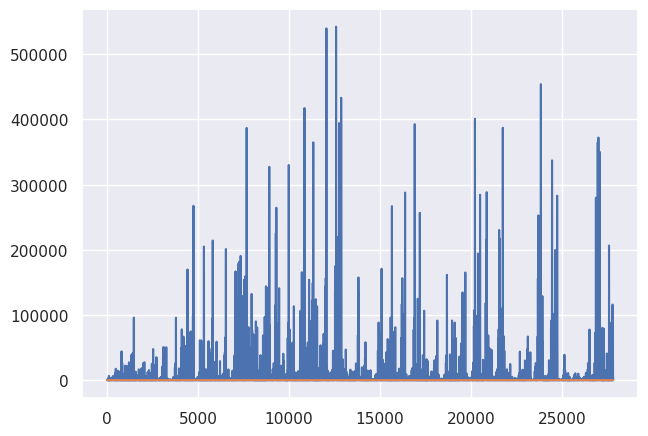

In [8]:
_ = plt.plot(mic[0])
_ = plt.plot(mic[1])

In [37]:
def check_RF_perf(X, y):
    clf = RandomForestClassifier(
        class_weight="balanced", n_jobs=24, max_features=None, max_depth=8
    )
    with parallel_backend("threading"):
        scores = cross_validate(
            clf,
            X,
            y,
            cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
            n_jobs=24,
            return_train_score=True,
            scoring="f1_macro",
        )
    _ = plt.plot(scores["test_score"], label="TEST")
    _ = plt.plot(scores["train_score"], label="TRAIN")
    _ = plt.legend()


def check_catNB_perf(X, y):
    min_c = X.nunique().astype("int").to_numpy() + 1
    # clf = RandomForestClassifier(class_weight='balanced',
    #                              n_jobs=24,
    # #                              max_features=None,
    #                              )
    class_prior = (y.value_counts() / X.shape[0]).sort_index().to_numpy()
    clf = CategoricalNB(
        fit_prior=True,
        alpha=0.0000003,
        min_categories=min_c,
        #                     class_prior=class_prior
    )
    categories_ = []
    for c in X.columns:
        categories_.append(sorted(list(X[c].unique())))

    work = make_pipeline(OrdinalEncoder(categories=categories_), clf)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.5,
        random_state=42,
        shuffle=True,
        stratify=y,
    )
    with parallel_backend("threading"):
        #     scores = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),n_jobs=24,return_train_score=True,scoring='f1_macro')
        y_pred = work.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_pred, y_test))

In [13]:
good_poly = np.argsort(mic[0][np.where(mic[0] > (10**5) * 1)])
good_f = list(poly_f_data.columns[good_poly])
X = poly_f_data[good_f]
y = data.target
print(len(good_f))
# for e in good_f:

#     print(e)

112


In [112]:
check_catNB_perf(X, y)

              precision    recall  f1-score   support

           0       0.58      0.54      0.56      2863
           1       0.63      0.66      0.64      3327

    accuracy                           0.60      6190
   macro avg       0.60      0.60      0.60      6190
weighted avg       0.60      0.60      0.60      6190



In [7]:
import phik

In [8]:
pd.options.compute.use_numba = False
data_bins = data.nunique().to_dict()
phi = data.global_phik(
    interval_cols=ordinal,
    bins=data_bins,
)
pd.options.compute.use_numba = True

In [122]:
data.groupby("nominal__customer_type")["binary__has_children"].sum()/data.groupby("nominal__customer_type")["binary__has_children"].count()

nominal__customer_type
0    0.396055
1    0.607772
2    0.326745
3    0.397863
Name: binary__has_children, dtype: float64

In [9]:
X = data[eval_data.columns]
y = data.target
X_eval = eval_data
pd.options.compute.use_numba = False
data_bins = X.nunique().to_dict()
groups = list(f_groups.values())+[ordinal,nominal,binary,interval]
phi_data = []
for fg in groups:
    phi = X.global_phik(
        interval_cols=fg,
        bins=data_bins,noise_correction=False
    )
    phi_data.append(phi[0])
pd.options.compute.use_numba = True
group_names = list(f_groups.keys())+["ordinal","nominal","binary","interval"]
phi_df = pd.DataFrame()
for i,p in enumerate(phi_data):
    phi_df[group_names[i]] = p.ravel()
    # p_ser = pd.Series(p.ravel(),name=i)
    
    # print(p)


pd.options.compute.use_numba = False
# data.phik_matrix(interval_cols=interval).style.background_gradient()
phik = data.phik_matrix(interval_cols=interval)

In [ ]:
plt.figure(figsize=(20,20))
_ = sns.heatmap(phik,cmap='viridis')

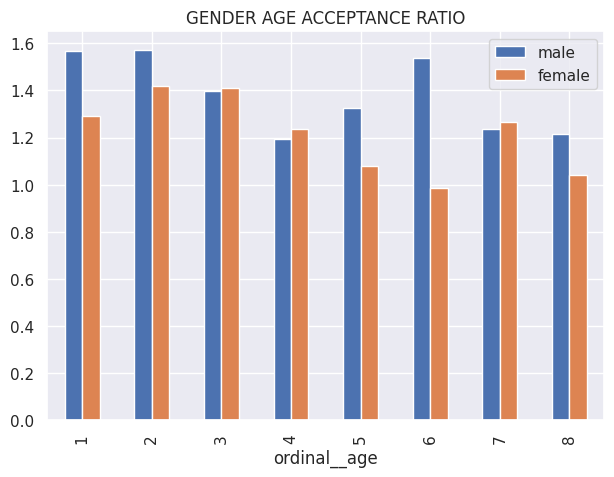

In [257]:
master_data = pd.concat([data[eval_data.columns], eval_data], ignore_index=True, axis=0)


def acceptance_ratio(df_):
    df = df_.copy()
    df.rename({1: "yes", 0: "no"}, axis="columns", inplace=True)
    df.eval("t = yes+no", inplace=True)
    df["yes"] = df["yes"] / df["t"]
    df["no"] = df["no"] / df["t"]
    df.eval("acceptance = (yes/no)", inplace=True)
    df = df.loc[:, ["acceptance"]]
    return df


# Male
male = data.groupby(bio)["target"].value_counts().unstack().loc[0, :, :]
male = acceptance_ratio(male)
# Female
female = data.groupby(bio)["target"].value_counts().unstack().loc[1, :, :]
female = acceptance_ratio(female)
gender_acceptance_rate = pd.DataFrame()
gender_acceptance_rate["male"] = male
gender_acceptance_rate["female"] = female
_ = gender_acceptance_rate.plot(kind="bar", title="Gender Age Acceptance Ratio".upper())

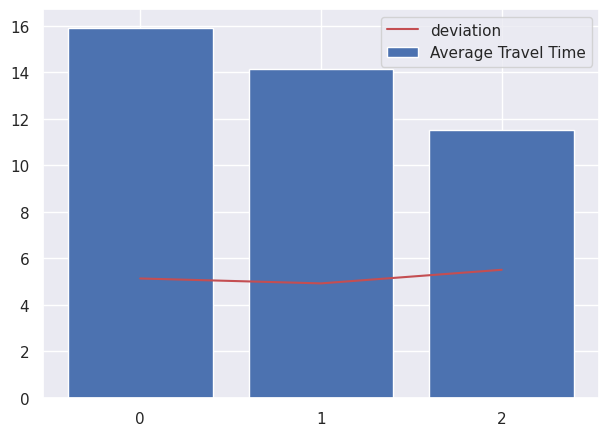

In [269]:
destination_travel_time = (
    master_data.groupby("nominal__drop_location")["interval__travel_time"]
    .value_counts()
    .unstack()
)
destination_travel_time = destination_travel_time.divide(
    destination_travel_time.sum(axis=1), axis=0
)
time_code = {7: "s", 10: "t", 14: "f", 18: "e", 22: "w"}
destination_travel_time.rename(time_code, axis="columns", inplace=True)
destination_travel_time.eval(
    "Ex = ((7*s)+ (10*t) + (14*f) + (18*e) + (22*w))", inplace=True
)
destination_travel_time.eval(
    "Ex2 = ((49*s)+ (100*t) + (196*f) + (324*e) + (484*w))", inplace=True
)
destination_travel_time.eval("Std = (Ex2 - (Ex*Ex))**0.5", inplace=True)
# _ = destination_travel_time['avg_time'].plot(kind='bar',title='avg. time to reach'.upper())
destination_travel_time
_ = plt.bar(
    x=destination_travel_time.index,
    height=destination_travel_time["Ex"],
    label="Average Travel Time",
)
_ = plt.xticks([0, 1, 2])
_ = plt.plot(destination_travel_time["Std"], "-r", label="deviation")
_ = plt.legend()

In [10]:
related_features = (((phik > 0.3).sum(axis=0)) > 1).to_dict()
relf = []

# print("Features that have Linear or Non Linear Relationships\n\n".upper())

for k, v in related_features.items():
    if v:
        relf.append(k)
crr = phik
relations = {f: {} for f in relf}
for f in relf:
    f_crr = crr[f].abs()
    f_rel = crr[f][f_crr[f_crr > 0.3].index].to_dict()
    del f_rel[f]
    relations[f] = f_rel

In [12]:
(relations['ordinal__age'])

{'nominal__marital_status': 0.3452504526896679,
 'nominal__job_industry': 0.5790477295300044,
 'binary__has_children': 0.520951715237399}

In [57]:
rel_adj = {}
for k in relations:
    rel_adj[k] = []
    for i,j in relations[k].items():
        rel_adj[k].append((i,j))

In [63]:
[f'{i} : {len(rel_adj[i])}' for i in rel_adj]

['ordinal__income_range : 2',
 'ordinal__no_visited_cold_drinks : 5',
 'binary__travelled_more_than_15mins_for_offer : 3',
 'ordinal__restaur_spend_less_than20 : 4',
 'nominal__marital_status : 5',
 'ordinal__age : 3',
 'binary__travelled_more_than_25mins_for_offer : 1',
 'ordinal__no_visited_bars : 5',
 'binary__restuarant_same_direction_house : 3',
 'nominal__customer_type : 2',
 'ordinal__qualif : 1',
 'ordinal__no_take_aways : 4',
 'nominal__job_industry : 9',
 'binary__restuarant_opposite_direction_house : 3',
 'binary__has_children : 2',
 'interval__temperature : 1',
 'ordinal__restaur_spend_greater_than20 : 4',
 'interval__travel_time : 1',
 'interval__season : 1',
 'ordinal__dest_distance : 1']

In [13]:
z = data.groupby('nominal__customer_type')[bio].count()
y = data.groupby('nominal__customer_type')[bio].sum()
y['female']=z['binary__gender'] - y['binary__gender']
y.eval('binary__gender = binary__gender/female',inplace=True)
y['mf_ratio'] = y['binary__gender']
y.drop(['binary__gender','female'],axis=1,inplace=True)
y

,ordinal__age,mf_ratio
nominal__customer_type,,
0,25110,1.034648
1,7300,1.181457
2,6792,0.993842
3,13576,1.037132


In [14]:
ratio_has_kids_per_marital_status = data.groupby('nominal__marital_status')['binary__has_children'].sum()/data.groupby('nominal__marital_status')['binary__has_children'].count()
ratio_has_kids_per_marital_status

nominal__marital_status
0    0.638661
1    0.190139
2    0.820312
3    0.279943
4    0.576577
Name: binary__has_children, dtype: float64

- Customer Type with children doesnt coincide with having children
- Divorced has the highest percent with kids

In [125]:
for b_f in binary:
    print(data.groupby(b_f)['target'].count())

binary__offer_expiration
0    5588
1    6791
Name: target, dtype: int64
binary__travelled_more_than_15mins_for_offer
0    5380
1    6999
Name: target, dtype: int64
binary__prefer_western_over_chinese
0    6107
1    6272
Name: target, dtype: int64
binary__travelled_more_than_25mins_for_offer
0    10901
1     1478
Name: target, dtype: int64
binary__gender
0    6044
1    6335
Name: target, dtype: int64
binary__restuarant_same_direction_house
0    9737
1    2642
Name: target, dtype: int64
binary__cooks_regularly
0    6195
1    6184
Name: target, dtype: int64
binary__is_foodie
0    6156
1    6223
Name: target, dtype: int64
binary__restuarant_opposite_direction_house
0    2632
1    9747
Name: target, dtype: int64
binary__has_children
0    7234
1    5145
Name: target, dtype: int64
binary__prefer_home_food
0    6068
1    6311
Name: target, dtype: int64


In [15]:
bio_pref_ratio = data.groupby(bio)[prefs+['target']].sum()/data.groupby(bio)[prefs+['target']].count()
bio_pref_ratio.style.background_gradient()

In [36]:
pref_profile_acceptance_rate = data.groupby('pref_profile')['target'].sum()/data.groupby('pref_profile')['target'].count()
pref_profile_acceptance_rate.sort_values(ascending=False)

pref_profile
8     0.595801
4     0.582129
7     0.577279
5     0.576159
10    0.575360
14    0.572827
9     0.572360
15    0.568534
13    0.567222
11    0.561160
3     0.560322
6     0.559392
0     0.554960
12    0.542459
2     0.539016
1     0.536193
Name: target, dtype: float64

In [26]:
# data[prefs]


In [24]:
int('0001',2)

1

In [33]:
eval_data['pref_profile'].value_counts().sort_index()

0     317
1     344
2     338
3     326
4     315
5     369
6     352
7     343
8     320
9     320
10    353
11    291
12    325
13    326
14    335
15    331
Name: pref_profile, dtype: int64

In [78]:
X = data[eval_data.columns]
y = data['target']
clf = HistGradientBoostingClassifier(categorical_features=[True]*30,random_state=42,learning_rate=0.01,max_iter=10000)
# clf = RandomForestClassifier(class_weight='balanced',n_jobs=-1,random_state=42,max_depth=5)
# clf = LogisticRegressionCV(max_iter=100000)
with parallel_backend('loky'):
    scores = cross_validate(clf,X,y,scoring='f1_macro',n_jobs=-1,return_train_score=True,cv=RepeatedStratifiedKFold(n_repeats=2))
scores

{'fit_time': array([75.06944752, 78.48986363, 45.385113  , 77.70727491, 45.73224139,
        74.08344245, 66.43768311, 66.2081449 , 66.11465883, 65.45720553]),
 'score_time': array([1.96948171, 2.01053929, 2.01040959, 1.94328904, 1.9921031 ,
        2.56649971, 2.00883341, 1.95350766, 1.97297239, 1.97237897]),
 'test_score': array([0.60368004, 0.59159674, 0.6032379 , 0.59903935, 0.58752296,
        0.60427344, 0.6001962 , 0.60368728, 0.60280055, 0.59509737]),
 'train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [55]:
X_master = pd.concat([data[eval_data.columns],eval_data],ignore_index=True,axis=0)
def get_logit_ordinal(X):
    probit = {c: {} for c in ordinal}

    for c in ordinal:
        vc = X_master[c].value_counts()
        N = X_master.shape[0]
        vc = vc / N
        probit_value = {val: 0 for val in X_master[c].unique()}
        for val in X_master[c].unique():
            probit_value[val] = np.log(
                (vc[vc.index <= val].sum()) / (vc[vc.index > val].sum() + 1e-09)
            )
        probit[c] = probit_value

    def transform_ordinal_to_logit(row):
        for c in ordinal:
            row[c] = probit[c][row[c]]
        return row

    probit_x = pd.DataFrame(X, columns=ordinal)
    probit_x = probit_x.apply(transform_ordinal_to_logit, axis=1)
    return probit_x

In [57]:
logit_X = get_logit_ordinal(X)

In [64]:
X_train, X_test,y_train, y_test = gen_train_test(X,y,test_size=0.2)

In [129]:
clf = HistGradientBoostingClassifier(categorical_features=[True]*30,random_state=42,learning_rate=0.1,max_iter=10000,early_stopping=True,scoring='f1_macro',validation_fraction=0.1,max_depth=9,min_samples_leaf=50
                                    )
X_train, X_test,y_train, y_test = gen_train_test(X,y,test_size=0.2)
clf = RandomForestClassifier(class_weight='balanced_subsample',n_jobs=-1,random_state=2)
clf.fit(X_train,y_train)
f1_score(y_test,clf.predict(X_test),average='macro')

0.5950658433860224

In [76]:
RF_feat_imp = pd.DataFrame(clf.feature_importances_,index=clf.feature_names_in_,columns=['Values'])
RF_feat_imp.style.background_gradient()

,Values
binary__offer_expiration,0.017478
ordinal__income_range,0.062426
ordinal__no_visited_cold_drinks,0.043796
binary__travelled_more_than_15mins_for_offer,0.017490
ordinal__restaur_spend_less_than20,0.039738
nominal__marital_status,0.032538
nominal__restaurant_type,0.053873
ordinal__age,0.054685
binary__prefer_western_over_chinese,0.019942
binary__travelled_more_than_25mins_for_offer,0.011161


In [177]:
consumer_groups = [None]*16
for i in range(16):
    consumer_groups[i] = data[data.pref_profile == i].index

other_fs = np.setdiff1d(data.columns,prefs+['target','pref_profile'])
data_chunks = []
for idx in consumer_groups:
    data_chunks.append(data.loc[idx,other_fs])
clf = RandomForestClassifier(n_jobs=-1,random_state=2,warm_start=True)
clf = HistGradientBoostingClassifier(categorical_features=[True]*25,random_state=42,learning_rate=0.1,max_iter=10000,early_stopping=True,scoring='f1_macro',validation_fraction=0.1,warm_start=True)
clfs = [clf]*16

In [182]:
for clf,X in zip(clfs,data_chunks):
#     print(len(X))
    X_train, X_test,y_train, y_test = gen_train_test(X,data.target.loc[X.index],test_size=0.15)
    clf.fit(X_train,y_train)
    clf.fit(X_train,y_train)
    clf.fit(X_train,y_train)
    clf.fit(X_train,y_train)
    clf.fit(X_train,y_train)
    clf.fit(X_train,y_train)
    clf.fit(X_train,y_train)
    clf.fit(X_train,y_train)
    
    sc = f1_score(y_test,clf.predict(X_test),average='macro')
    print(sc)

0.6066411238825032
0.5177033492822967
0.48770491803278687
0.4900551162233405
0.6219707973396529
0.5410628019323672
0.5281385281385282
0.5081664098613251
0.5300331559873545
0.5547527658613682
0.5985124468731027
0.5500463722622531
0.5840051366198189
0.5932526585991933
0.5502437703141929
0.5252079002079002


In [176]:
len(other_fs)

25